# History Summary

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

### Get all History File Paths

In [2]:
output_dir = './summary/'
history_dir = './history/'

versions, datasets, fx_models, clf_models, runs, paths = [], [], [], [], [], []

for version in os.listdir(history_dir):
    version_dir = os.path.join(history_dir,version)
    for dataset in os.listdir(version_dir):
        dataset_dir = os.path.join(version_dir,dataset)
        for model in os.listdir(dataset_dir):
            fx_model = '_'.join(model.split('_')[:-1])
            clf_model = model.split('_')[-1]
            model_dir = os.path.join(dataset_dir,model)
            for run in os.listdir(model_dir):
                path = os.path.join(model_dir,run,'history.pt')
                if not os.path.isfile(path): continue
                versions.append(version)
                datasets.append(dataset)
                fx_models.append(fx_model)
                clf_models.append(clf_model)
                runs.append(run)
                paths.append(path)

history_files = pd.DataFrame.from_dict(dict(version=versions,dataset=datasets,fx_model=fx_models,clf_model=clf_models,run=runs,path=paths))
history_files.describe()

,version,dataset,fx_model,clf_model,run,path
count,420,420,420,420,420,420
unique,2,7,6,2,5,420
top,v1.2,RAVDESS,WAV2VEC2_BASE,DENSE,Run1,./history/v1.2/RAVDESS/WAV2VEC2_BASE_DENSE/Run...
freq,210,60,70,210,84,1


### Get by Classifier

In [3]:
dense_history_files = history_files[history_files.clf_model=='DENSE']
probing_history_files = history_files[history_files.clf_model=='PROBING']

##### PROBING

In [11]:
mean_accs, std_accs, max_accs, models, datasets = [], [], [], [], []
for model in probing_history_files.fx_model.unique():
    for dataset in probing_history_files.dataset.unique():
        run_df = probing_history_files[(probing_history_files.dataset==dataset) & (probing_history_files.fx_model==model)]
        test_accs = []
        for run in range(run_df.shape[0]):
            history = torch.load(run_df.iloc[run].path)
            hs_idx = np.argmax(history['val_acc'],axis=0)
            ts_acc = np.array(history['test_acc']).transpose()
            test_accs.append([acc[idx] for acc, idx in zip (ts_acc,hs_idx)])

        mean_accs.append(np.mean(test_accs,axis=0))
        max_accs.append(np.max(test_accs))
        std_accs.append(np.std(test_accs,axis=0))
        models.append(model)
        datasets.append(dataset)

probing_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,mean_accuracy=mean_accs,std_accuracy=std_accs,max_accuracy=max_accs))
probing_summary.sort_values(['dataset','model']).reset_index(drop=True).drop(['max_accuracy'],axis=1).to_csv(os.path.join(output_dir,'probing_summary.csv'))

In [15]:
probing_summary.head()

,dataset,model,mean_accuracy,std_accuracy,max_accuracy
0,RAVDESS,WAV2VEC2_LARGE_XLSR300M,"[51.66666626930237, 52.06666648387909, 57.9999...","[1.2823595737115998, 2.559514615458038, 3.0037...",75.666666
1,AESDD,WAV2VEC2_LARGE_XLSR300M,"[46.47343039512634, 54.009660482406616, 54.685...","[3.462119768248277, 1.7657651257335993, 2.1035...",78.260869
2,EMOVO,WAV2VEC2_LARGE_XLSR300M,"[23.979591727256775, 24.387754797935486, 19.08...","[2.1646120550146044, 1.5609241420959523, 2.824...",42.857143
3,EmoDB,WAV2VEC2_LARGE_XLSR300M,"[81.66666746139526, 83.80952477455139, 85.0, 8...","[2.672613268724893, 1.4285703500114662, 2.2080...",98.809522
4,ShEMO,WAV2VEC2_LARGE_XLSR300M,"[86.12903356552124, 87.68817186355591, 88.5483...","[1.0965622904922228, 1.332204287935997, 0.6496...",93.010753


##### DENSE

In [13]:
mean_accs, std_accs, max_accs, models, datasets = [], [], [], [], []
for model in dense_history_files.fx_model.unique():
    for dataset in dense_history_files.dataset.unique():
        run_df = dense_history_files[(dense_history_files.dataset==dataset) & (dense_history_files.fx_model==model)]
        test_accs = []
        for run in range(run_df.shape[0]):
            history = torch.load(run_df.iloc[run].path)
            test_accs.append(history['test_acc'][history['val_acc'].index(max(history['val_acc']))])
        mean_accs.append(np.mean(test_accs))
        std_accs.append(np.std(test_accs))
        max_accs.append(np.max(test_accs))
        models.append(model)
        datasets.append(dataset)

dense_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,max_acuracy=max_accs,mean_accuracy=mean_accs,std_accuracy=std_accs))

In [17]:
top_1, top_3, layers = [], [], []
for row in range(dense_summary.shape[0]):
    dense_row = dense_summary.iloc[row]
    probing_row = probing_summary[(probing_summary.model==dense_row.model)&(probing_summary.dataset==dense_row.dataset)]
    prob_acc = probing_row.mean_accuracy
    accs = sorted(prob_acc.iloc[0])[-3:]
    mean = np.mean(accs)
    std = np.std(accs)
    top_3.append(f'{round(mean,2)} ({round(std,2)})')
    top_1.append(probing_row.max_accuracy.iloc[0])
    layers.append(np.argsort(prob_acc.iloc[0])[-3:]+1)
    
dense_summary['probing_max_acc'] = top_1
dense_summary['probing_top_3'] = top_3
dense_summary['probing_top_layers'] = layers

In [18]:
dense_summary.sort_values(['dataset','model']).reset_index(drop=True).to_csv(os.path.join(output_dir,'dense_summary.csv'))

In [89]:
dense_summary.head()

,dataset,model,max_acuracy,mean_accuracy,std_accuracy,probing_top_3,probing_top_layers,probing_max_acc
0,RAVDESS,WAV2VEC2_BASE,64.666665,58.999999,4.366540,60.4 (0.22),"[6, 7, 5]",60.666667
1,AESDD,WAV2VEC2_BASE,62.318838,59.903382,2.386296,62.54 (2.56),"[3, 5, 4]",64.541063
2,EMOVO,WAV2VEC2_BASE,35.204083,30.000000,3.168199,37.04 (1.66),"[8, 4, 5]",39.387755
3,EmoDB,WAV2VEC2_BASE,91.666669,86.428572,3.417310,86.11 (0.96),"[6, 3, 5]",86.904761
4,ShEMO,WAV2VEC2_BASE,91.397852,90.376344,0.748840,89.34 (0.46),"[7, 6, 5]",89.784945


In [77]:
top_3

['60.40000081062317 (0.21773221393490863)',
 '62.544283072153725 (2.555470532682603)',
 '37.040816148122154 (1.6642352386525066)',
 '86.11111124356587 (0.9589712700005795)',
 '89.33691620826721 (0.45690134401969124)',
 '59.74358995755514 (1.307440745062154)',
 '61.47355874379476 (0.5750938235447285)',
 '66.68888926506042 (0.6913937617121101)',
 '68.27697197596233 (0.2986670768632998)',
 '40.40816346804301 (0.3332639950051022)',
 '96.19047562281291 (5.619579801452538e-07)',
 '91.00358446439107 (0.3681481062075482)',
 '69.54415957132976 (1.545305002011494)',
 '63.99286905924479 (0.5168316657215952)',
 '70.57777802149455 (0.08314711924169164)',
 '74.52495972315471 (0.48201750613559247)',
 '49.18367326259613 (2.8290642425030725)',
 '99.04761830965678 (0.33671735429131405)',
 '91.97132706642151 (0.19794538514331608)',
 '74.41595435142517 (0.14527089083799655)',
 '65.90017835299174 (0.11643431037532358)',
 '69.6666665871938 (0.7620627487723874)',
 '70.20933906237285 (0.5921019681582254)',
 '

---

In [71]:
prob_acc.iloc[0]

array([52.00000048, 53.59999895, 58.73333216, 58.86666656, 60.66666722,
       60.1333344 , 60.40000081, 58.53333354, 57.79999852, 56.80000067,
       48.19999993, 50.93333185])

In [74]:
sorted(prob_acc.iloc[0])

[48.199999928474426,
 50.93333184719086,
 52.00000047683716,
 53.59999895095825,
 56.80000066757202,
 57.79999852180481,
 58.53333353996277,
 58.73333215713501,
 58.86666655540466,
 60.13333439826965,
 60.40000081062317,
 60.666667222976685]

In [75]:
np.argsort(prob_acc.iloc[0])[-3:]

array([5, 6, 4])

### Plots

#### Dataset wise

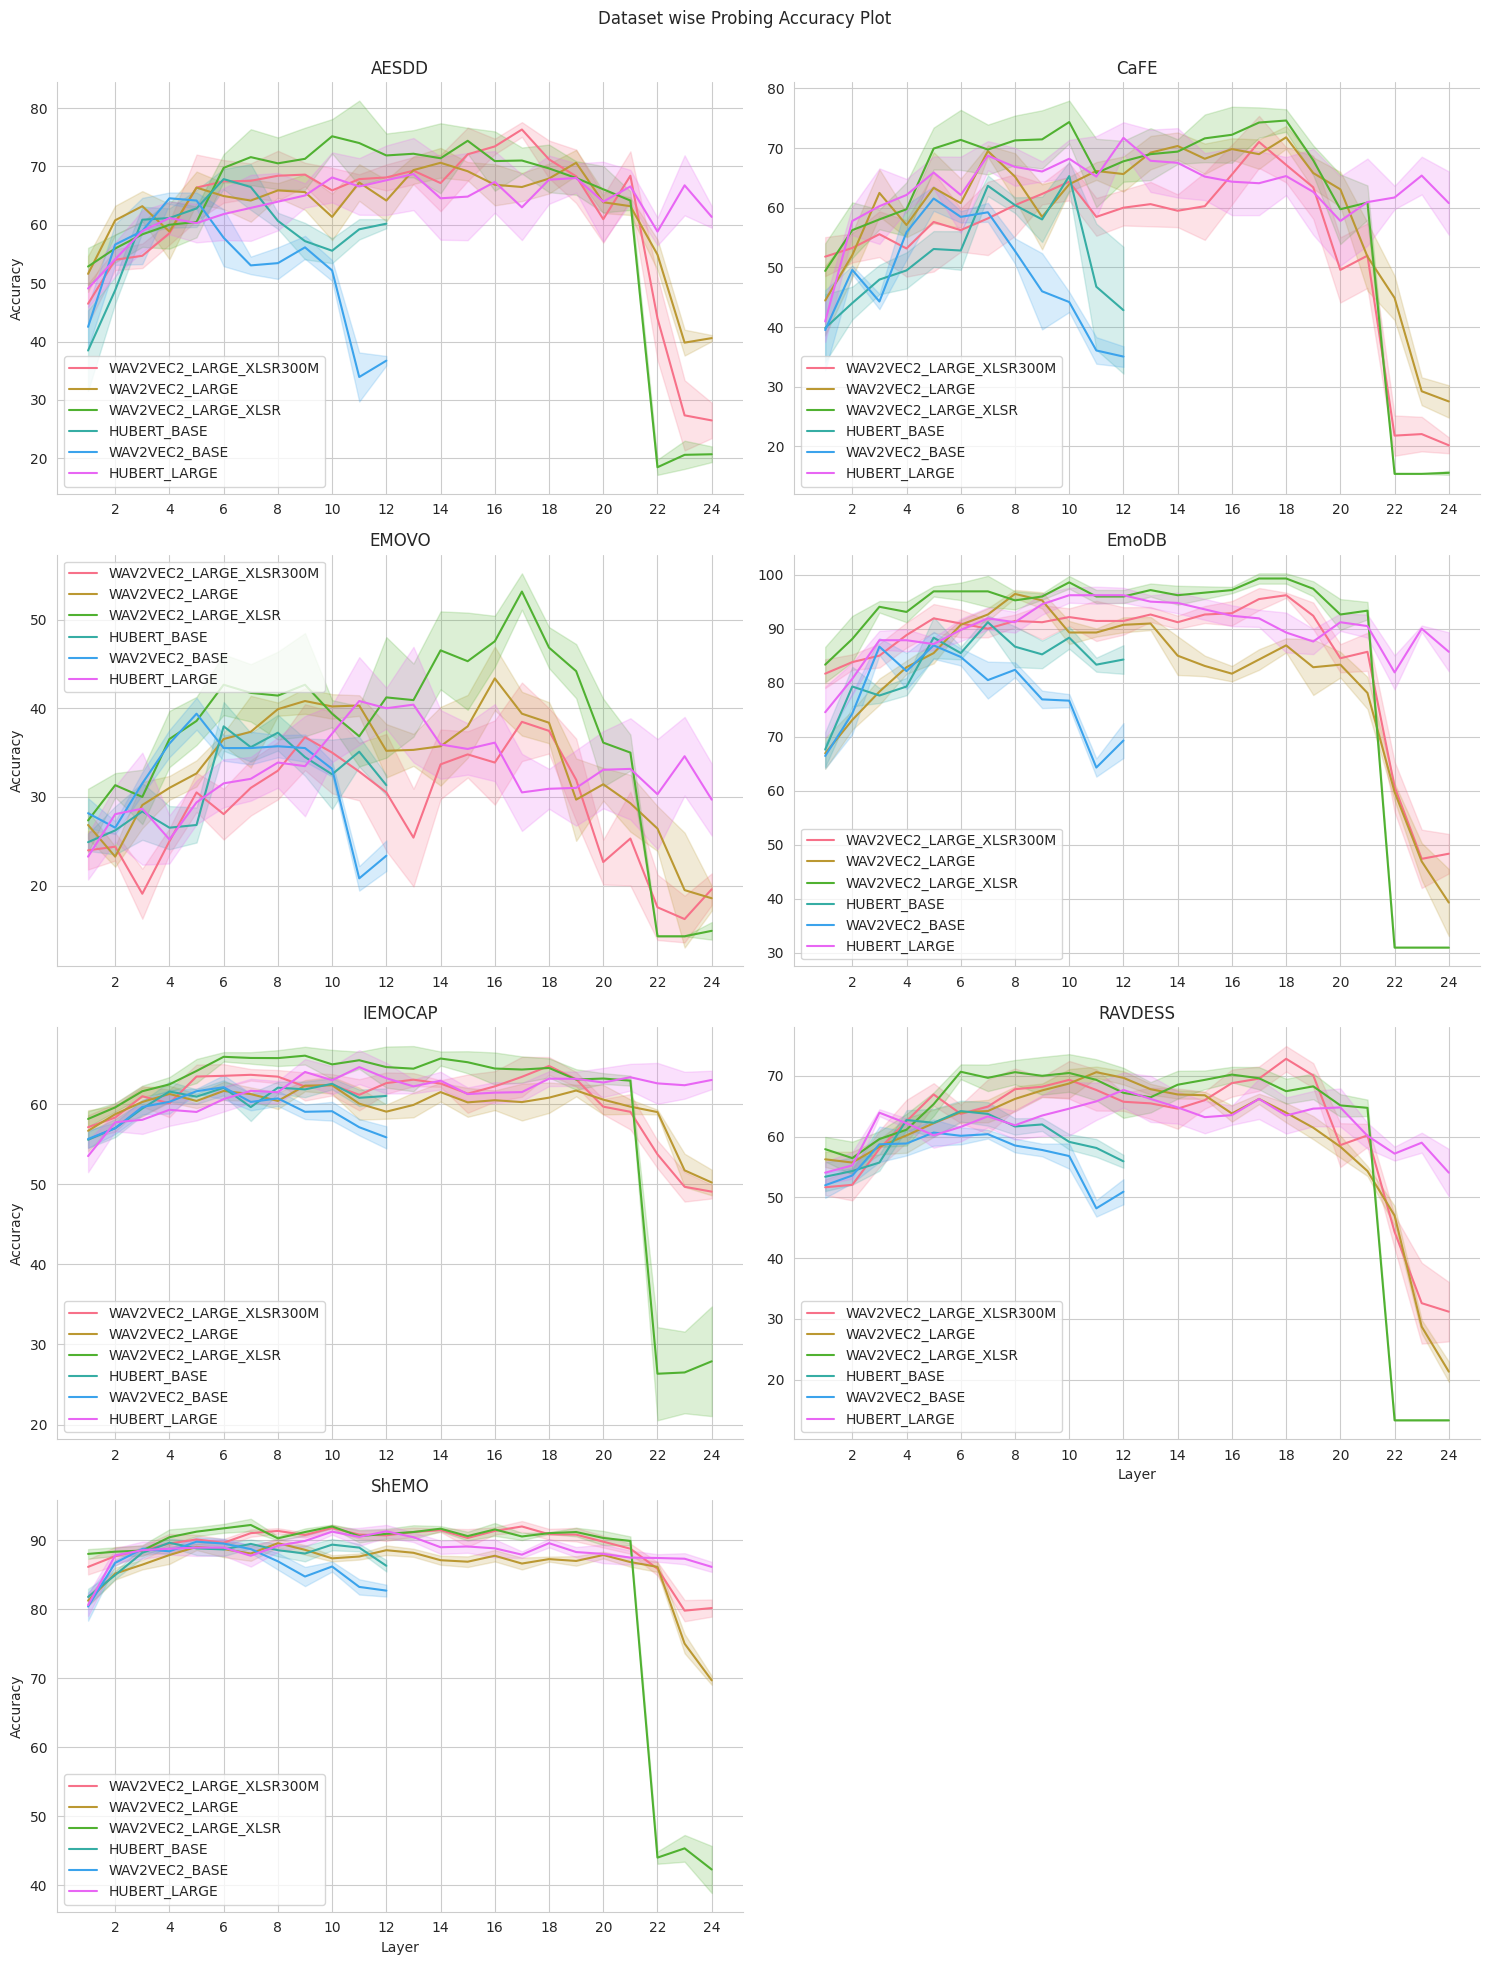

In [31]:
# Set figure
fig, ax = plt.subplots(4, 2,figsize=(15,20))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
datasets = sorted(probing_summary.dataset.unique())
for idx in range(len(datasets)):
    ax = axes[idx]
    dataset= datasets[idx]
    mean_accs, layers, models = [], [], []
    df = probing_summary[probing_summary.dataset==dataset]
    for row in range(df.shape[0]):
        mean_accs.extend(df.iloc[row].mean_accuracy)
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)+np.array(df.iloc[row].std_accuracy))
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)-np.array(df.iloc[row].std_accuracy))
        models.extend(([df.iloc[row].model]*len(df.iloc[row].mean_accuracy)*3))
        layers.extend([*range(1,len(df.iloc[row].mean_accuracy)+1)]*3)
    df = pd.DataFrame.from_dict(dict(model=models,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='model',dashes=False,palette=sns.color_palette("husl",len(df.model.unique())),errorbar=('ci',100),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(dataset)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,25,2)],labels=[*range(2,25,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-2].set_xlabel("Layer")
axes[-3].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
axes[6].set_ylabel("Accuracy")
axes[-1].axis('off')
plt.suptitle('Dataset wise Probing Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'dataset_wise_probing_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'dataset_wise_probing_accuracy_plot.svg'),bbox_inches="tight");

# plt.clf();
# plt.close('all');

#### Model wise

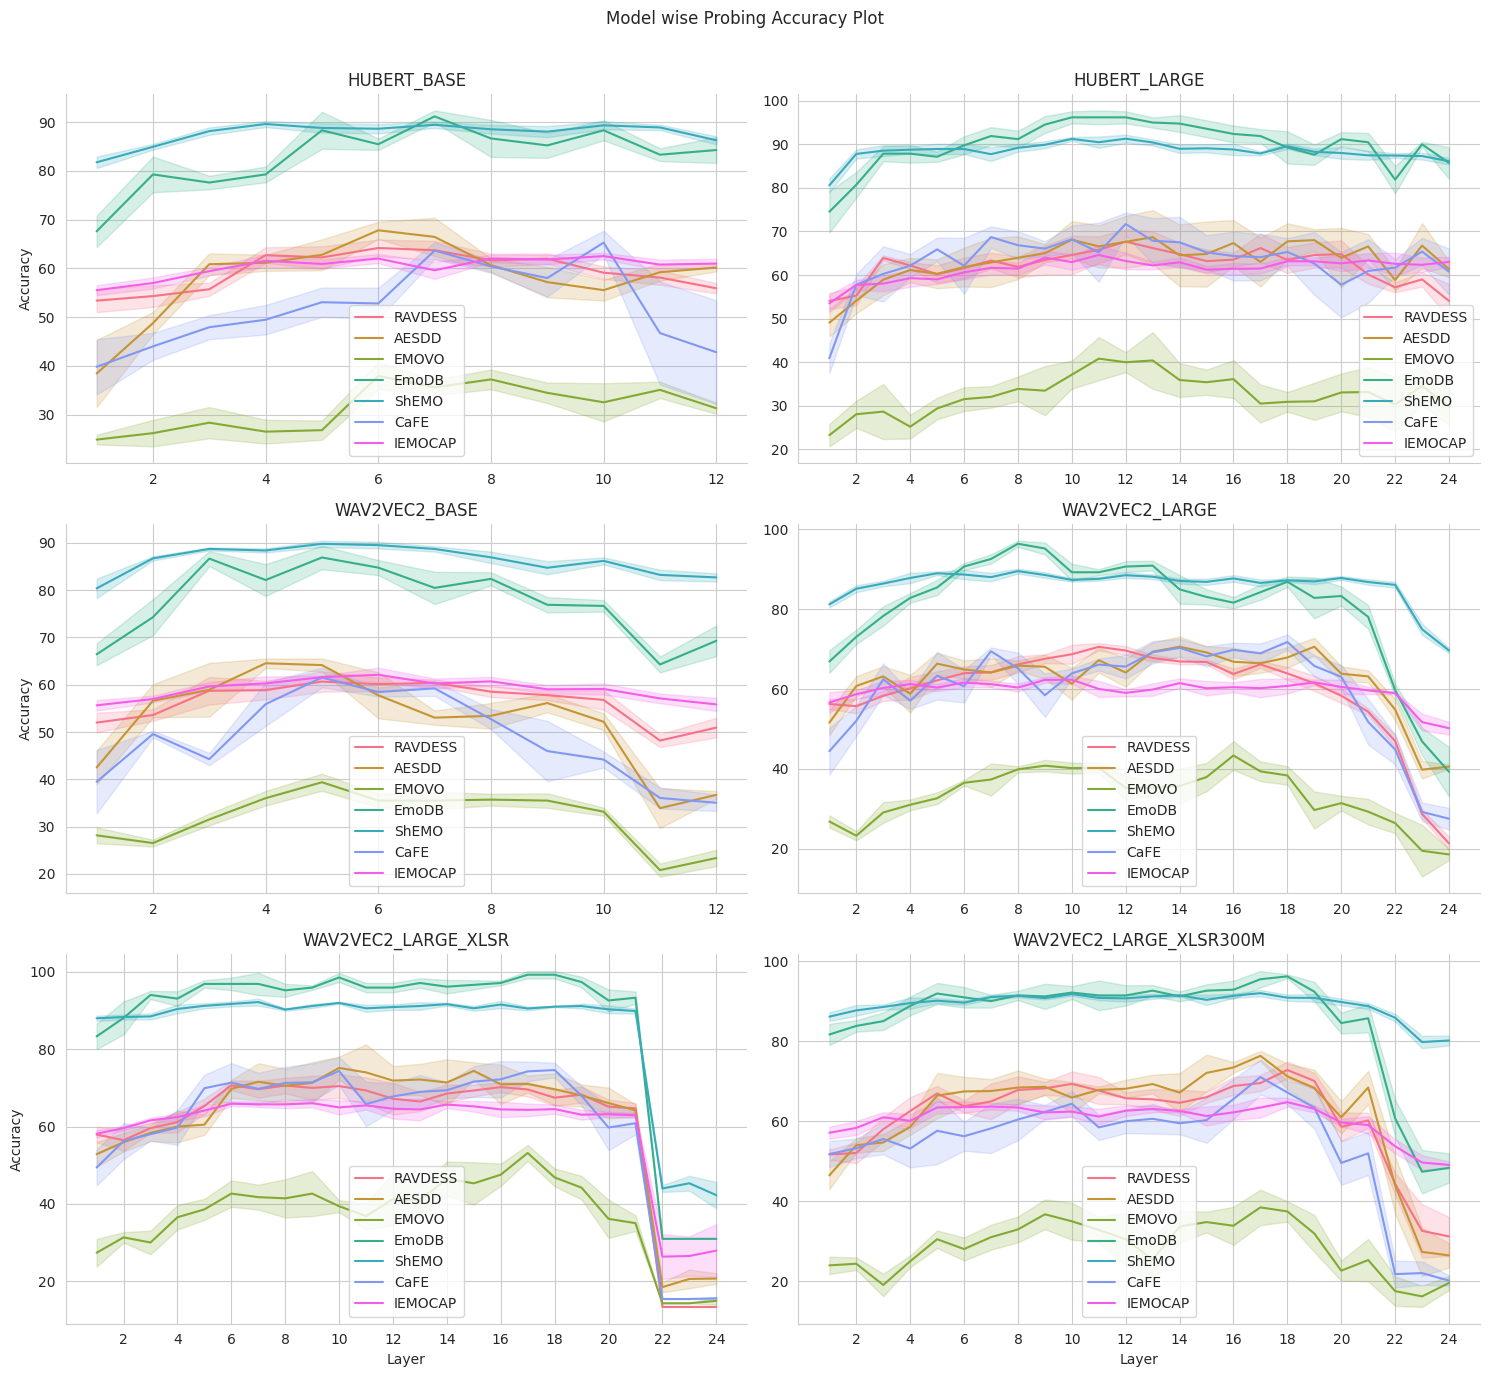

In [47]:
# Set figure
fig, ax = plt.subplots(3, 2,figsize=(15,14))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
models = sorted(probing_summary.model.unique())
for idx in range(len(models)):
    ax = axes[idx]
    model= models[idx]
    mean_accs, layers, datasets = [], [], []
    df = probing_summary[probing_summary.model==model]
    for row in range(df.shape[0]):
        mean_accs.extend(df.iloc[row].mean_accuracy)
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)+np.array(df.iloc[row].std_accuracy))
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)-np.array(df.iloc[row].std_accuracy))
        datasets.extend(([df.iloc[row].dataset]*len(df.iloc[row].mean_accuracy)*3))
        layers.extend([*range(1,len(df.iloc[row].mean_accuracy)+1)]*3)
    df = pd.DataFrame.from_dict(dict(dataset=datasets,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='dataset',dashes=False,palette=sns.color_palette("husl",len(df.dataset.unique())),errorbar=('ci',100),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(model)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,len(df.layer.unique())+1,2)],labels=[*range(2,len(df.layer.unique())+1,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-1].set_xlabel("Layer")
axes[-2].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
plt.suptitle('Model wise Probing Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'model_wise_probing_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'model_wise_probing_accuracy_plot.svg'),bbox_inches="tight");


# plt.clf();
# plt.close('all');

In [48]:
plt.clf()
plt.close('all')